Connected to .venv (Python 3.10.7)

 <div style="text-align: right">   </div>
 Introduction to Deep Learning (2024)

 **Assignment 2 - Sequence processing using RNNs**
 <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">

 # Introduction

 The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs).
 Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

 <img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

 In this assignment you will be working with three different kinds of models, based on input/output data modalities:

 1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation

 2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.

 3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.

 ### Description

 Let us suppose that we want to develop a neural network that learns how to add or subtract

 two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or

 ’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a

 sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,

 we want to build a model that generalizes well - if the network can extract the underlying principles behind

 the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate

 valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),

 2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

 The example above describes a text-to-text sequence mapping scenario. However, we can also use different

 modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit

 dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

 *To work on this notebook you should create a copy of it.*


 # Function definitions for creating the datasets

 First we need to create our datasets that are going to be used for training our models.

 In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library.
 We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed # type: ignore
from tensorflow.keras.layers import RepeatVector, Conv2D, ConvLSTM2D # type: ignore

2024-12-12 23:21:32.133773: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 23:21:32.157158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 23:21:32.157176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 23:21:32.157965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 23:21:32.161827: I tensorflow/core/platform/cpu_feature_guar

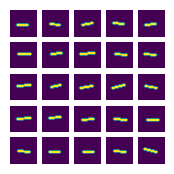

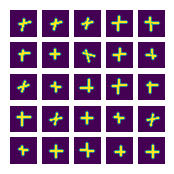

In [ ]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:
    
    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=False)
                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=False)
                result_image = []
                
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())
                    
                X_text.append(query_string)
                X_img.append(np.stack(query_image))

                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '

    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

 # Creating our data

 The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

   **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]
   **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

   **y_text**: strings containing answers of length 3: ['  2', '156']
   **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #8311

X_text: "41-55" = y_text: "-14"


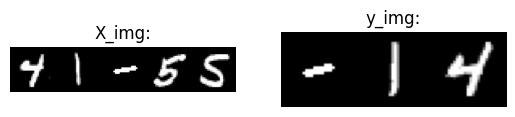

Query #8672

X_text: "43+36" = y_text: " 79"


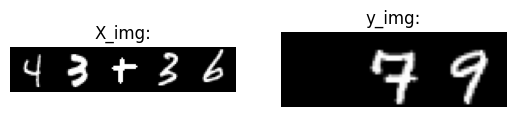

Query #2668

X_text: "13+34" = y_text: " 47"


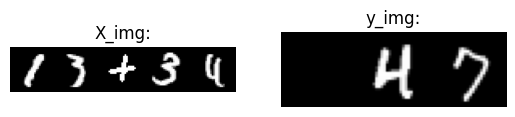

Query #5841

X_text: "29-20" = y_text: "  9"


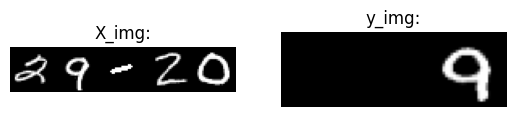

Query #9717

X_text: "48-58" = y_text: "-10"


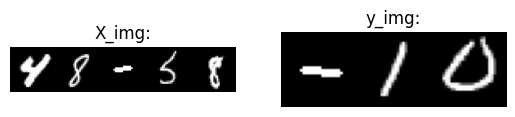

Query #3142

X_text: "15+71" = y_text: " 86"


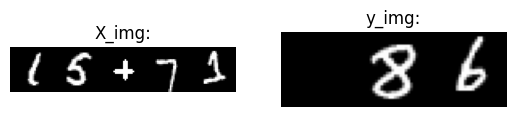

Query #3571

X_text: "17-85" = y_text: "-68"


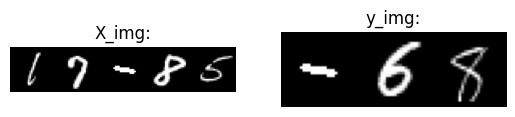

Query #8088

X_text: "40+44" = y_text: " 84"


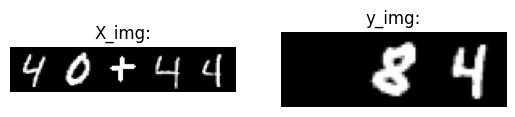

Query #5671

X_text: "28-35" = y_text: " -7"


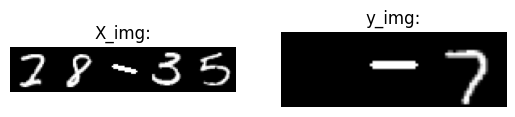

Query #2243

X_text: "11-21" = y_text: "-10"


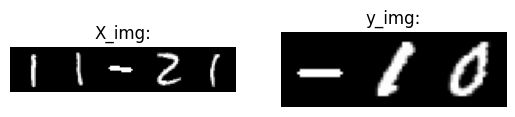

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

 ## Helper functions



 The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


 ---

 ---



 ## III. Text to image RNN Model



 Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.



 The goal here is to use **X_text** as inputs and **y_img** as outputs.

(84000, 28, 28) (84000,)
[' ' '-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
5


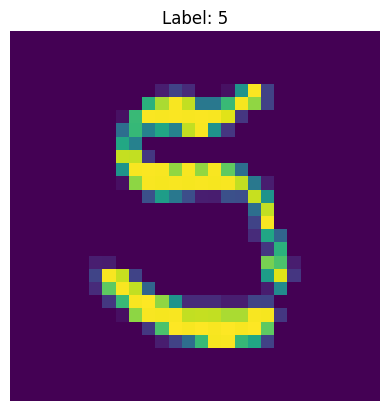

(67200,)
(67200, 28, 28, 1)
5
X_train shape: (67200, 28, 28, 1)
67200 train samples
5
Input shape is  (28, 28, 1)


In [ ]:
# Your code

#MNIST CLASSIFICATION

import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pandas as pd

class DatasetPrep():
    def __init__(self, X_train, X_valid, y_train, y_valid, X_test, y_test, input_shape):
        self.input_shape = input_shape
        self.X_train = X_train
        self.X_valid = X_valid
        self.y_train = y_train
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        
def encode_out(labels):
    n = len(labels)
    characters = "1234567890- "
    char_map = dict(zip(characters, range(len(characters))))
    one_hot = np.zeros([n, len(characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([len(characters)])
        for j, char in enumerate(label):
            m[char_map[char]] = 1
        one_hot[i] = m
    return one_hot

def decode_out(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join(["1234567890- "[i] for i in pred])
    
    return predicted

def load_data(num_classes):
    img_rows, img_cols = 28, 28
    item_size = 7000
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    
    # Concatenate Train and Test
    X = np.concatenate((x_train, x_test), axis=0)
    Y = np.concatenate((y_train.astype(str), y_test.astype(str)), axis=0)
    
    # Add Minus Images
    X = np.concatenate((X, generate_images(item_size, '-')), axis=0)
    Y = np.concatenate((Y, np.full((item_size), '-')), axis=0)
    
    #Add Empty Images
    X = np.concatenate((X, np.zeros([item_size, img_rows, img_cols])), axis=0)
    Y = np.concatenate((Y, np.full((item_size), ' ')), axis=0)
    
    print(X.shape, Y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.50, random_state=42)
    
    if keras.backend.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
        
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    
    plt.imshow(X_train[0])
    plt.title(f"Label: {y_train[0]}")
    unique_classes = np.unique(y_train)
    print(unique_classes)
    print(y_train[0])
    plt.axis('off')  # Remove the axes for better visualization
    plt.show()
   
    print(y_train.shape)
    print(X_train.shape)
    print(y_train[0])

    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_valid /= 255
    X_test /= 255
    
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    #print(X_valid.shape[0], 'valid samples')
    print(y_train[0])
    

        
    y_train = encode_out(y_train)
    y_valid = encode_out(y_valid)
    y_test = encode_out(y_test)
    input_shape = X_train.shape[1:]
    print("Input shape is ", input_shape)
  
    dataset_p = DatasetPrep(X_train, X_valid, y_train, y_valid, X_test, y_test, input_shape)
    
    return dataset_p

num_classes = 12
dataset_p = load_data(num_classes)

In [ ]:
def build_image_classifier(input_shape, kernel_initializer, activation):
    #regularizer
    kernel_regularizer = keras.regularizers.L2(0.01)
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation=activation, input_shape=input_shape, kernel_initializer=kernel_initializer, padding='same'))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same'))

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer))
    
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(128, activation=activation,kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer))
    
    model.add(Dropout(0.2))    
    model.add(Dense(num_classes, activation='softmax'))

    # Create the optimizer with the tunable parameters
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0001, weight_decay = 1e-4
        ),
        #optimizer = optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 9, 9, 32)          0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                        

2024-12-12 23:21:51.826299: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:21:51.850368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 23:21:51.850460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/20


2024-12-12 23:21:52.489562: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-12 23:21:52.590011: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-12 23:21:52.626701: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-12-12 23:21:52.626710: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-12 23:21:52.626734: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-12-12 23:21:52.9320

1050/1050 [==============================] - 5s 3ms/step - loss: 2.5675 - accuracy: 0.9056 - val_loss: 1.4790 - val_accuracy: 0.9711 - lr: 1.0000e-04
Epoch 2/20
1050/1050 [==============================] - 4s 4ms/step - loss: 1.0626 - accuracy: 0.9698 - val_loss: 0.7305 - val_accuracy: 0.9773 - lr: 1.0000e-04
Epoch 3/20
1050/1050 [==============================] - 5s 5ms/step - loss: 0.5488 - accuracy: 0.9765 - val_loss: 0.4064 - val_accuracy: 0.9780 - lr: 1.0000e-04
Epoch 4/20
1050/1050 [==============================] - 6s 5ms/step - loss: 0.3219 - accuracy: 0.9801 - val_loss: 0.2583 - val_accuracy: 0.9810 - lr: 1.0000e-04
Epoch 5/20
1050/1050 [==============================] - 6s 5ms/step - loss: 0.2195 - accuracy: 0.9818 - val_loss: 0.1840 - val_accuracy: 0.9846 - lr: 1.0000e-04
Epoch 6/20
1050/1050 [==============================] - 6s 5ms/step - loss: 0.1693 - accuracy: 0.9832 - val_loss: 0.1501 - val_accuracy: 0.9840 - lr: 1.0000e-04
Epoch 7/20
1050/1050 [=======================

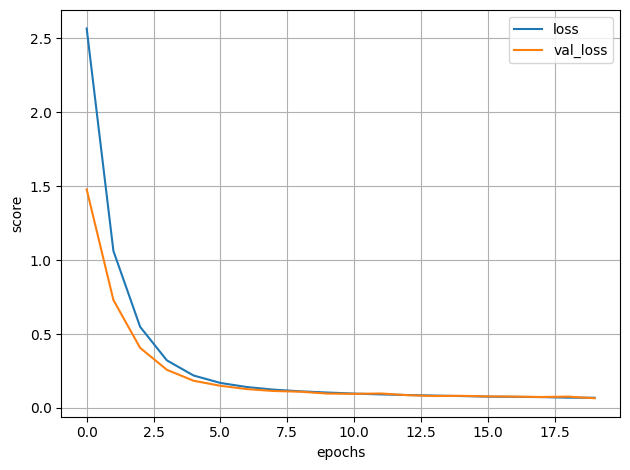

In [ ]:
input_shape = dataset_p.input_shape
kernel_initializer = 'he_normal'
activation = 'relu'

image_classifier_model = build_image_classifier(input_shape, kernel_initializer, activation)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"mnist_classification_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = image_classifier_model.fit(
    dataset_p.X_train,
    dataset_p.y_train,
    validation_data=(dataset_p.X_valid, dataset_p.y_valid),
    batch_size=64,
    epochs=20,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)


import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('mnist_classification.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

263/263 [==============================] - 0s 1ms/step - loss: 0.0648 - accuracy: 0.9904
[0.06484346836805344, 0.9903571605682373]
(1, 28, 28)
1/1 [==============================] - 0s 130ms/step
[4]


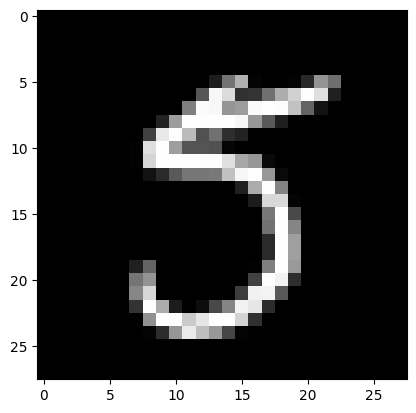

In [ ]:
import tensorflow as tf


score3 = image_classifier_model.evaluate(dataset_p.X_test, dataset_p.y_test) 
print(score3)
images = tf.unstack(y_img[100], axis=0)
single_image = images[1]  # Shape: (28, 28, 1)
plt.imshow(single_image, cmap='gray')

# to check for blank image 
if np.all(single_image==0):
    print(True)
    
single_image_batch = tf.expand_dims(single_image, axis=0)  # Shape: (1, 28, 28, 1)
print(single_image_batch.shape)

predictions = image_classifier_model.predict(single_image_batch)

predicted_classes = predictions.argmax(axis=1)
print(predicted_classes)

In [ ]:
# TEXT TO IMAGE PREPARATION
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_img, test_size=0.20, random_state=42) 
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

_, _, y_train_text, y_test_text = train_test_split(X_text_onehot, y_text, test_size=0.20, random_state=42)
_, _, y_test_text, y_valid_text = train_test_split(_, y_test_text, test_size=0.5, random_state=42) 

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, GlobalMaxPooling2D, Conv2DTranspose,
                                     Dense, LSTM, RepeatVector, Dropout, BatchNormalization, Reshape,
                                     LayerNormalization, Flatten, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_text2img_model():

    text2img = tf.keras.Sequential()

    text2img.add(LSTM(256, input_shape=(None, len(unique_characters))))
    text2img.add(Dropout(0.1))
    text2img.add(RepeatVector(max_answer_length))

    # add reshape 
    text2img.add(LSTM(256, return_sequences=True))
    text2img.add(Dropout(0.1))
    
    # text2img.add(TimeDistributed(Dense( 28 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))
    
    # lets slowly increase the dense 
    text2img.add(TimeDistributed(Dense( 7 * 7 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))
    text2img.add(Reshape((3, 7, 7, 28)))

    #default_args=dict(kernel_size=(3,3),  padding='same', activation='relu')

    text2img.add(TimeDistributed(Conv2DTranspose(filters=7, kernel_size=(2, 2), strides=2, padding='same', 
                                                 activation='relu')))
    
    text2img.add(TimeDistributed(Conv2DTranspose(filters=7, kernel_size=(2, 2) ,strides=2, padding='same', 
                                                 activation = 'relu')))
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')))

    # Compile the model
    text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    text2img.summary()
    #text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    

    return text2img

model = build_text2img_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            525312    
                                                                 


2024-12-12 23:23:38.119385: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


 dropout_3 (Dropout)         (None, 3, 256)            0         
                                                                 
 time_distributed (TimeDist  (None, 3, 1372)           352604    
 ributed)                                                        
                                                                 
 reshape (Reshape)           (None, 3, 7, 7, 28)       0         
                                                                 
 time_distributed_1 (TimeDi  (None, 3, 14, 14, 7)      791       
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 3, 28, 28, 7)      203       
 stributed)                                                      
                                                                 
 batch_normalization (Batch  (None, 3, 28, 28, 7)      28        
 Normalization)                                                  
          

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
 

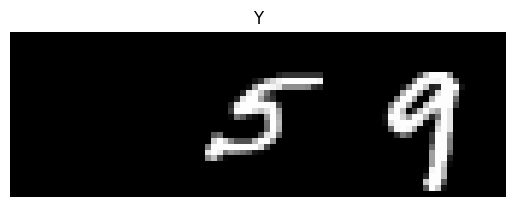

In [ ]:
print(y_train)

plt.imshow(np.hstack(y_train[200]), cmap='gray')  # Display the frame in grayscale
plt.title(f"Y")
plt.axis("off")
plt.show()

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"text_to_image_best_previous.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=50,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)

Epoch 1/50


2024-12-12 23:23:39.786089: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:23:40.240253: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:23:40.240367: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:23:40.240729: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12 23:23:40.241049: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-12

500/500 [==============================] - 9s 12ms/step - loss: 0.0981 - accuracy: 0.8338 - val_loss: 0.0564 - val_accuracy: 0.8661 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 3s 7ms/step - loss: 0.0523 - accuracy: 0.8605 - val_loss: 0.0513 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - 3s 5ms/step - loss: 0.0506 - accuracy: 0.8606 - val_loss: 0.0493 - val_accuracy: 0.8595 - lr: 0.0010
Epoch 4/50
500/500 [==============================] - 2s 5ms/step - loss: 0.0489 - accuracy: 0.8611 - val_loss: 0.0493 - val_accuracy: 0.8671 - lr: 0.0010
Epoch 5/50
500/500 [==============================] - 3s 7ms/step - loss: 0.0481 - accuracy: 0.8610 - val_loss: 0.0477 - val_accuracy: 0.8656 - lr: 0.0010
Epoch 6/50
500/500 [==============================] - 2s 3ms/step - loss: 0.0477 - accuracy: 0.8610 - val_loss: 0.0479 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 7/50
500/500 [==============================] - 2s 3ms/step - loss: 0.0474

In [ ]:
model.save(f'submission1_text_to_image_previous.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Path to the saved model file
model_path = 'submission1_text_to_image_previous.keras'

# Load the model
model = load_model(model_path)

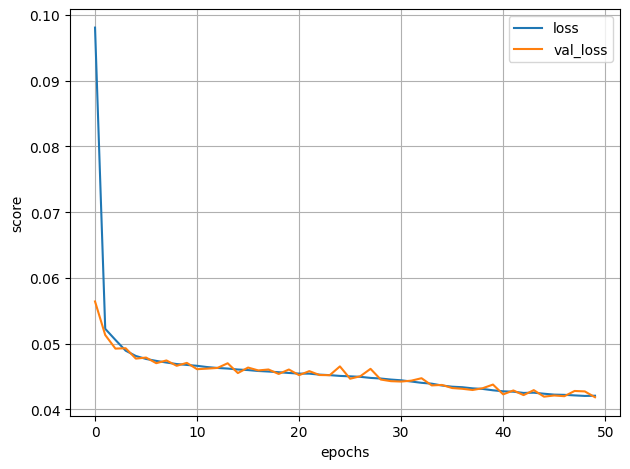

In [ ]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('text_to_image_history_previous.csv')
plt.plot(data_history['loss'], label='loss')
plt.plot(data_history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

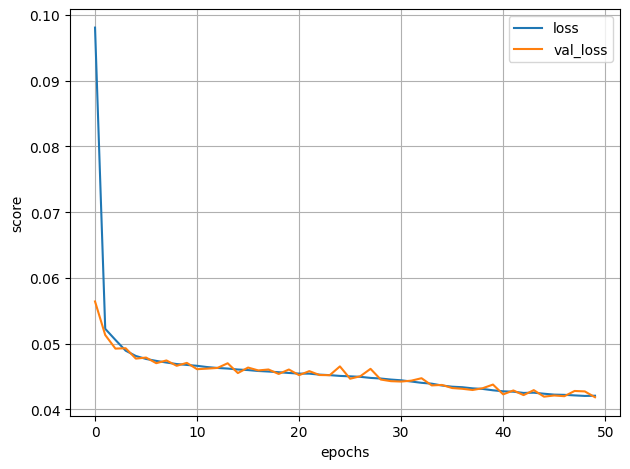

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

data_history = pd.DataFrame(history.history)
data_history.to_csv('text_to_image_history_previous.csv')
plt.plot(data_history['loss'], label='loss')
plt.plot(data_history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
output_images = model.predict(X_test).reshape((X_test.shape[0] * 3, 28, 28))

predicted_nhot = image_classifier_model.predict(output_images)
predicted_images_values = []
for i in range(X_test.shape[0]):
    predicted_images_values.append(decode_out(predicted_nhot[i*3:i*3+3]))


print(len(predicted_images_values))

print("Accuracy Score: ", accuracy_score(y_test_text, predicted_images_values))

188/188 [==============================] - 0s 476us/step
2000
Accuracy Score:  0.6485


 <div style="text-align: right">   </div>
 Introduction to Deep Learning (2024)

 **Assignment 2 - Sequence processing using RNNs**
 <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">

 # Introduction

 The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs).
 Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

 <img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

 In this assignment you will be working with three different kinds of models, based on input/output data modalities:

 1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation

 2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.

 3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.

 ### Description

 Let us suppose that we want to develop a neural network that learns how to add or subtract

 two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or

 ’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a

 sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,

 we want to build a model that generalizes well - if the network can extract the underlying principles behind

 the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate

 valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),

 2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.

 The example above describes a text-to-text sequence mapping scenario. However, we can also use different

 modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit

 dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

 *To work on this notebook you should create a copy of it.*


 # Function definitions for creating the datasets

 First we need to create our datasets that are going to be used for training our models.

 In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library.
 We will use these operand signs together with the MNIST dataset to represent the digits.

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, LSTM, Flatten, TimeDistributed # type: ignore
from tensorflow.keras.layers import RepeatVector, Conv2D, ConvLSTM2D # type: ignore

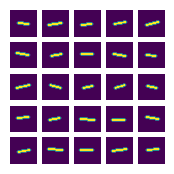

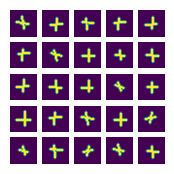

In [ ]:
from scipy.ndimage import rotate


# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):
    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))

In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:
    
    @return:
    X_text: '51+21' -> text query of an arithmetic operation (5)
    X_img : Stack of MNIST images corresponding to the query (5 x 28 x 28) -> sequence of 5 images of size 28x28
    y_text: '72' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (3 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []

                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())
                    
                X_text.append(query_string)
                X_img.append(np.stack(query_image))

                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '

    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)

 # Creating our data

 The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

   **X_text**: strings containing queries of length 5: ['  1+1  ', '11-18', ...]
   **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

   **y_text**: strings containing answers of length 3: ['  2', '156']
   **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #2171

X_text: "10-85" = y_text: "-75"


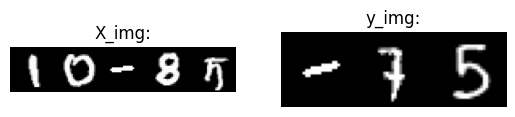

Query #80

X_text: "0+40 " = y_text: "40 "


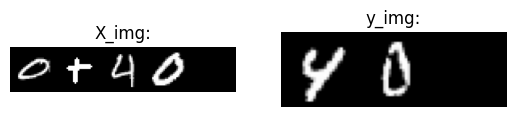

Query #4901

X_text: "24-50" = y_text: "-26"


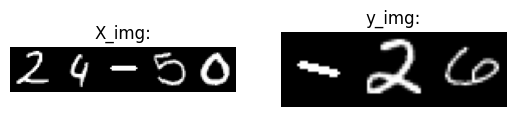

Query #5706

X_text: "28+53" = y_text: "81 "


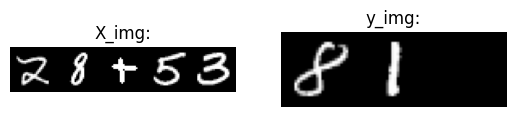

Query #6892

X_text: "34+46" = y_text: "80 "


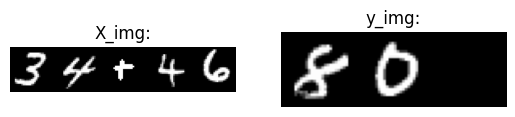

Query #1826

X_text: "9+13 " = y_text: "22 "


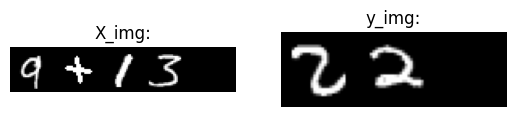

Query #246

X_text: "1+23 " = y_text: "24 "


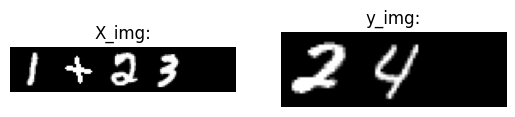

Query #8074

X_text: "40+37" = y_text: "77 "


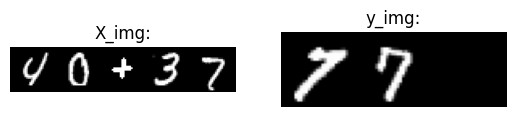

Query #3337

X_text: "16-68" = y_text: "-52"


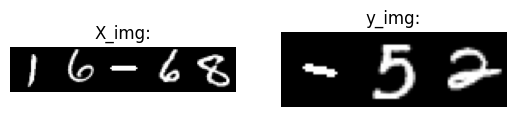

Query #2395

X_text: "11-97" = y_text: "-86"


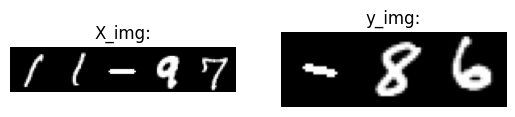

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 3    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)

## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
        
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

 ## Helper functions



 The functions below will help with input/output of the data.

In [ ]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs

# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join([unique_characters[i] for i in pred])
    
    return predicted

X_text_onehot = encode_labels(X_text)
y_text_onehot = encode_labels(y_text)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


 ---

 ---



 ## III. Text to image RNN Model



 Hint: to make this model work really well you could use deconvolutional layers in your decoder (you might need to look up ***Conv2DTranspose*** layer). However, regular vector-based decoder will work as well.



 The goal here is to use **X_text** as inputs and **y_img** as outputs.

(84000, 28, 28) (84000,)
[' ' '-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
5


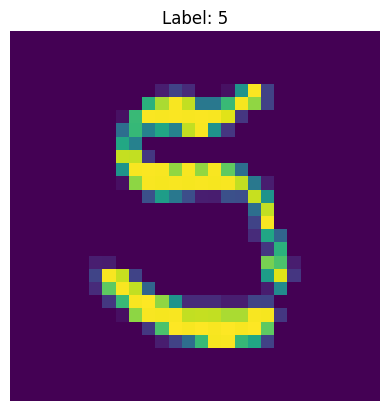

(67200,)
(67200, 28, 28, 1)
5
X_train shape: (67200, 28, 28, 1)
67200 train samples
5
Input shape is  (28, 28, 1)


In [ ]:
# Your code

#MNIST CLASSIFICATION

import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import pandas as pd

class DatasetPrep():
    def __init__(self, X_train, X_valid, y_train, y_valid, X_test, y_test, input_shape):
        self.input_shape = input_shape
        self.X_train = X_train
        self.X_valid = X_valid
        self.y_train = y_train
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        
def encode_out(labels):
    n = len(labels)
    characters = "1234567890- "
    char_map = dict(zip(characters, range(len(characters))))
    one_hot = np.zeros([n, len(characters)])
    
    for i, label in enumerate(labels):
        m = np.zeros([len(characters)])
        for j, char in enumerate(label):
            m[char_map[char]] = 1
        one_hot[i] = m
    return one_hot

def decode_out(labels):
    pred = np.argmax(labels, axis=1)
    predicted = ''.join(["1234567890- "[i] for i in pred])
    
    return predicted

def load_data(num_classes):
    img_rows, img_cols = 28, 28
    item_size = 7000
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    
    # Concatenate Train and Test
    X = np.concatenate((x_train, x_test), axis=0)
    Y = np.concatenate((y_train.astype(str), y_test.astype(str)), axis=0)
    
    # Add Minus Images
    X = np.concatenate((X, generate_images(item_size, '-')), axis=0)
    Y = np.concatenate((Y, np.full((item_size), '-')), axis=0)
    
    #Add Empty Images
    X = np.concatenate((X, np.zeros([item_size, img_rows, img_cols])), axis=0)
    Y = np.concatenate((Y, np.full((item_size), ' ')), axis=0)
    
    print(X.shape, Y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.50, random_state=42)
    
    if keras.backend.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_valid = X_valid.reshape(X_valid.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
        
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    
    plt.imshow(X_train[0])
    plt.title(f"Label: {y_train[0]}")
    unique_classes = np.unique(y_train)
    print(unique_classes)
    print(y_train[0])
    plt.axis('off')  # Remove the axes for better visualization
    plt.show()
   
    print(y_train.shape)
    print(X_train.shape)
    print(y_train[0])

    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_valid /= 255
    X_test /= 255
    
    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    #print(X_valid.shape[0], 'valid samples')
    print(y_train[0])
    

        
    y_train = encode_out(y_train)
    y_valid = encode_out(y_valid)
    y_test = encode_out(y_test)
    input_shape = X_train.shape[1:]
    print("Input shape is ", input_shape)
  
    dataset_p = DatasetPrep(X_train, X_valid, y_train, y_valid, X_test, y_test, input_shape)
    
    return dataset_p

num_classes = 12
dataset_p = load_data(num_classes)

In [ ]:
def build_image_classifier(input_shape, kernel_initializer, activation):
    #regularizer
    kernel_regularizer = keras.regularizers.L2(0.01)
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), activation=activation, input_shape=input_shape, kernel_initializer=kernel_initializer, padding='same'))
    
    model.add(Conv2D(32, kernel_size=(3, 3), activation=activation, kernel_initializer=kernel_initializer, padding='same'))

    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, (3, 3), activation=activation, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer))
    
    model.add(Dropout(0.1))
    model.add(Flatten())
    model.add(Dense(128, activation=activation,kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer))
    
    model.add(Dropout(0.2))    
    model.add(Dense(num_classes, activation='softmax'))

    # Create the optimizer with the tunable parameters
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=0.0001, weight_decay = 1e-4
        ),
        #optimizer = optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()
    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                      

2024-12-12 23:29:09.512629: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1050/1050 [==============================] - 5s 4ms/step - loss: 2.3738 - accuracy: 0.9103 - val_loss: 1.2707 - val_accuracy: 0.9700 - lr: 1.0000e-04
Epoch 2/20
1050/1050 [==============================] - 5s 4ms/step - loss: 0.8920 - accuracy: 0.9717 - val_loss: 0.6073 - val_accuracy: 0.9782 - lr: 1.0000e-04
Epoch 3/20
1050/1050 [==============================] - 4s 4ms/step - loss: 0.4640 - accuracy: 0.9767 - val_loss: 0.3550 - val_accuracy: 0.9775 - lr: 1.0000e-04
Epoch 4/20
1050/1050 [==============================] - 5s 4ms/step - loss: 0.2847 - accuracy: 0.9802 - val_loss: 0.2362 - val_accuracy: 0.9815 - lr: 1.0000e-04
Epoch 5/20
1050/1050 [==============================] - 5s 5ms/step - loss: 0.2011 - accuracy: 0.9823 - val_loss: 0.1740 - val_accuracy: 0.9849 - lr: 1.0000e-04
Epoch 6/20
1050/1050 [==============================] - 5s 5ms/step - loss: 0.1593 - accuracy: 0.9837 - val_loss: 0.1498 - val_accuracy: 0.9832 - lr: 1.0000e-04
Epoch 7/20
1050/1050 [=======================

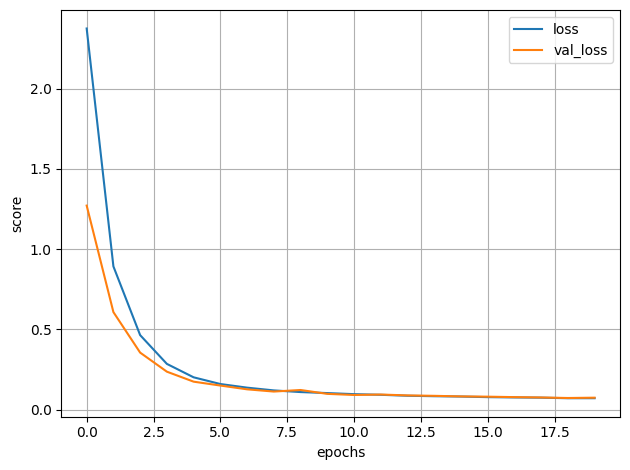

In [ ]:
input_shape = dataset_p.input_shape
kernel_initializer = 'he_normal'
activation = 'relu'

image_classifier_model = build_image_classifier(input_shape, kernel_initializer, activation)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"mnist_classification_best.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = image_classifier_model.fit(
    dataset_p.X_train,
    dataset_p.y_train,
    validation_data=(dataset_p.X_valid, dataset_p.y_valid),
    batch_size=64,
    epochs=20,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)


import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('mnist_classification.csv')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

263/263 [==============================] - 0s 886us/step - loss: 0.0680 - accuracy: 0.9895
[0.06795023381710052, 0.9895238280296326]
(1, 28, 28)
1/1 [==============================] - 0s 32ms/step
[9]


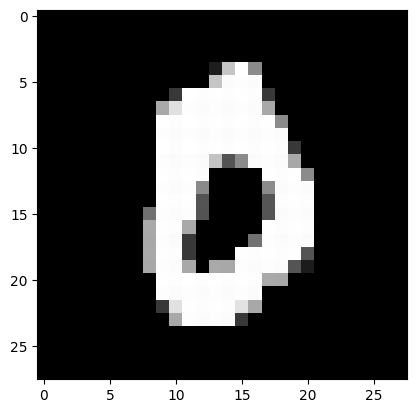

In [ ]:
import tensorflow as tf


score3 = image_classifier_model.evaluate(dataset_p.X_test, dataset_p.y_test) 
print(score3)
images = tf.unstack(y_img[100], axis=0)
single_image = images[1]  # Shape: (28, 28, 1)
plt.imshow(single_image, cmap='gray')

# to check for blank image 
if np.all(single_image==0):
    print(True)
    
single_image_batch = tf.expand_dims(single_image, axis=0)  # Shape: (1, 28, 28, 1)
print(single_image_batch.shape)

predictions = image_classifier_model.predict(single_image_batch)

predicted_classes = predictions.argmax(axis=1)
print(predicted_classes)

In [ ]:
# TEXT TO IMAGE PREPARATION
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_img, test_size=0.20, random_state=42) 
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42) 

_, _, y_train_text, y_test_text = train_test_split(X_text_onehot, y_text, test_size=0.20, random_state=42)
_, _, y_test_text, y_valid_text = train_test_split(_, y_test_text, test_size=0.5, random_state=42) 

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (ConvLSTM2D, TimeDistributed, GlobalMaxPooling2D, Conv2DTranspose,
                                     Dense, LSTM, RepeatVector, Dropout, BatchNormalization, Reshape,
                                     LayerNormalization, Flatten, GlobalAveragePooling1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def build_text2img_model():

    text2img = tf.keras.Sequential()

    text2img.add(LSTM(256, input_shape=(None, len(unique_characters))))
    text2img.add(Dropout(0.1))
    text2img.add(RepeatVector(max_answer_length))

    # add reshape 
    text2img.add(LSTM(256, return_sequences=True))
    text2img.add(Dropout(0.1))
    
    # text2img.add(TimeDistributed(Dense( 28 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))
    
    # lets slowly increase the dense 
    text2img.add(TimeDistributed(Dense( 7 * 7 * 28, activation='sigmoid', kernel_regularizer=l2(0.001))))
    text2img.add(Reshape((3, 7, 7, 28)))

    #default_args=dict(kernel_size=(3,3),  padding='same', activation='relu')

    text2img.add(TimeDistributed(Conv2DTranspose(filters=7, kernel_size=(2, 2), strides=2, padding='same', 
                                                 activation='relu')))
    
    text2img.add(TimeDistributed(Conv2DTranspose(filters=7, kernel_size=(2, 2) ,strides=2, padding='same', 
                                                 activation = 'relu')))
    text2img.add(BatchNormalization())
    text2img.add(TimeDistributed(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='sigmoid')))

    # Compile the model
    text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    text2img.summary()
    #text2img.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    

    return text2img

model = build_text2img_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256)               276480    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 3, 256)            0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 3, 256)            525312    
                                                                 
 dropout_7 (Dropout)         (None, 3, 256)            0         
                                                                 
 time_distributed_4 (TimeDi  (None, 3, 1372)           352604    
 stributed)                                           

[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]

  [[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
 

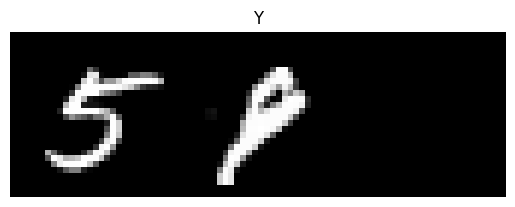

In [ ]:
print(y_train)

plt.imshow(np.hstack(y_train[200]), cmap='gray')  # Display the frame in grayscale
plt.title(f"Y")
plt.axis("off")
plt.show()

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
        f"text_to_image_best_previous.keras", save_best_only=True
    )
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # metric to monitor
    patience=8,          # number of epochs to wait for improvement
    restore_best_weights=True  # restore the best weights after stopping
)

lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=32,
    epochs=50,
    callbacks = [checkpoint_cb, early_stopping, lr_scheduler]
)

Epoch 1/50
500/500 [==============================] - 6s 8ms/step - loss: 0.1036 - accuracy: 0.8256 - val_loss: 0.0637 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 2/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0550 - accuracy: 0.8631 - val_loss: 0.0524 - val_accuracy: 0.8678 - lr: 0.0010
Epoch 3/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0509 - accuracy: 0.8621 - val_loss: 0.0490 - val_accuracy: 0.8637 - lr: 0.0010
Epoch 4/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0495 - accuracy: 0.8618 - val_loss: 0.0489 - val_accuracy: 0.8628 - lr: 0.0010
Epoch 5/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0489 - accuracy: 0.8617 - val_loss: 0.0481 - val_accuracy: 0.8645 - lr: 0.0010
Epoch 6/50
500/500 [==============================] - 4s 8ms/step - loss: 0.0485 - accuracy: 0.8614 - val_loss: 0.0478 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 7/50
500/500 [==============================] - 4s 8ms/step - lo

In [ ]:
model.save(f'submission1_text_to_image_previous.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Path to the saved model file
model_path = 'submission1_text_to_image_previous.keras'

# Load the model
model = load_model(model_path)

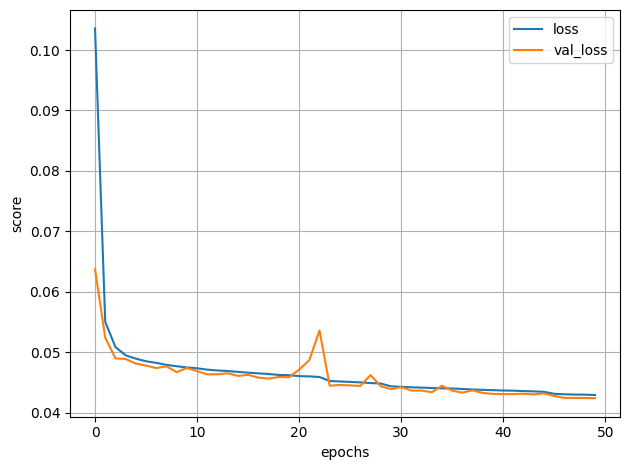

In [ ]:
import pandas as pd
data_history = pd.DataFrame(history.history)
data_history.to_csv('text_to_image_history_previous.csv')
plt.plot(data_history['loss'], label='loss')
plt.plot(data_history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

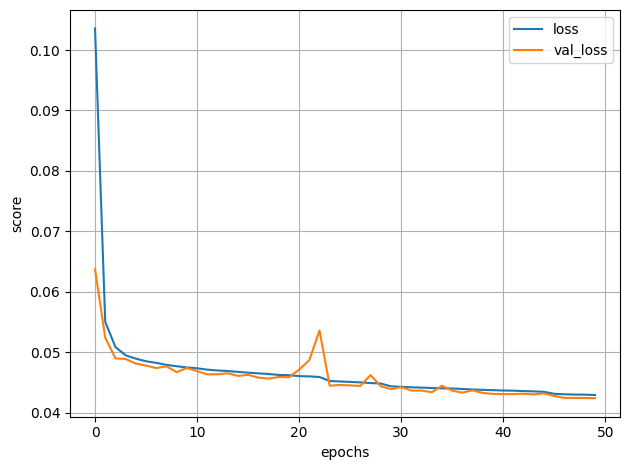

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

data_history = pd.DataFrame(history.history)
data_history.to_csv('text_to_image_history_previous.csv')
plt.plot(data_history['loss'], label='loss')
plt.plot(data_history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('score')
plt.legend(loc="best")


plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
output_images = model.predict(X_test).reshape((X_test.shape[0] * 3, 28, 28))

predicted_nhot = image_classifier_model.predict(output_images)
predicted_images_values = []
for i in range(X_test.shape[0]):
    predicted_images_values.append(decode_out(predicted_nhot[i*3:i*3+3]))


print(len(predicted_images_values))

print("Accuracy Score: ", accuracy_score(y_test_text, predicted_images_values))

188/188 [==============================] - 0s 836us/step
2000
Accuracy Score:  0.2555


In [ ]:
# def predict_model(model, text):
#     # Encodes the text and predicts the output image
#     encoded_text = encode_labels([text], max_len=5)
#     predicted_image = model.predict(encoded_text).reshape((3, 28, 28))
#     return predicted_image

# Input texts
# inputs = ['10-30', '42+25', '48+81']

# Predict the images for each input
# output_images = [predict_model(model, text) for text in inputs]